In [256]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym

import random
from collections import deque

env = gym.make("CartPole-v1")

""" state: [position, velocity, angle, radial velocity]
action: [left, right]
left is minus, right is plus"""

def generate_episodes(n_ep, env):
    for _ in range(n_ep):
        observation, info = env.reset()

        while True:
            action = env.action_space.sample()
            observation, reward, terminated, truncated, info = env.step(action)
            # print(observation, action)
            
            if terminated or truncated:
                break

In [257]:
def simple_policy(state):
    return int(state[2] < 0)

def less_simple_policy(state):
    r = np.random.rand()
    threshold = 0.5
    if np.absolute(state[2]) > 0.12:
        return int(state[2] < 0)
    else:
        return np.random.randint(0, 2)

In [258]:
env = gym.make("CartPole-v1")

def test_policy(n_ep, policy, _env):
    reward_list = []
    
    for _ in range(n_ep):
        reward_count = 0
        observation, info = _env.reset()
        
        while True:
            action = policy(observation)
            observation, reward, terminated, truncated, info = _env.step(action)
            reward_count += reward
            # print(observation, action)
            
            if terminated or truncated:
                break
        reward_list.append(reward_count)
    return np.mean(reward_list)

avg_reward_1 = test_policy(1000, simple_policy, env)
avg_reward_2 = test_policy(1000, less_simple_policy, env)

print(avg_reward_1, avg_reward_2)
env.close()

8.727 20.831


In [259]:
state, info = env.reset()
action = env.action_space.sample()
observation, reward, terminated, truncated, info = env.step(action)
info

{}

In [260]:
torch.argmax(torch.tensor([1, 100, 4, 5]))

tensor(1)

In [261]:
def epsilon_greedy(env, Q_net, S, epsilon):
    r = torch.rand(1)
    if r > epsilon:
        return torch.argmax(Q_net.forward(S))
    else:
        return torch.tensor([[env.action_space.sample()]])

class DQN(nn.Module):
    def __init__(self, in_dim, out_dim) -> None:
        super().__init__()
        # note to self: nn.Linear() represents the transformation, not the matrices themselves.
        self.il = nn.Linear(in_dim, 50)
        self.ol = nn.Linear(50, out_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = F.relu(self.il(x))
        return F.relu(self.ol(x))
        
class Replay_Memory():
    def __init__(self, cap):
        self.memory = deque([], maxlen = cap)

    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        mem_sample = random.sample(self.memory, batch_size)
    
        states, actions, rewards, next_states, dones = zip(*mem_sample)
        
        return (torch.stack(states), torch.stack(actions), torch.stack(rewards), 
                torch.stack(next_states), torch.stack(dones))

    def __len__(self):
        return len(self.memory)

def DQL(_env, n_ep):
    state_dim = _env.observation_space.shape[0]
    action_dim = _env.action_space.n
    buffer_cap = 100000
    
    replay_buffer = Replay_Memory(buffer_cap)
    behaviour_net = DQN(state_dim, action_dim)
    target_net = DQN(state_dim, action_dim)

    cumulative_reward_list = []
    
    target_net.load_state_dict(behaviour_net.state_dict())
    target_net.eval()
    
    optimizer = torch.optim.Adam(behaviour_net.parameters(), lr=0.01)
    loss_func = nn.MSELoss();

    n_steps = 0
    decay_min = 0.01
    decay_const = 0.01
    successes = 0
    _gamma = 0.99

    for i in range(n_ep):
        S, info = _env.reset()
        S = torch.tensor(S, dtype=torch.float32)
        done = False
        

        while not done:
            epsilon = decay_min + (1 - decay_min) * np.exp(-decay_const * i)
            
            A = int(epsilon_greedy(env, behaviour_net, S, epsilon))
            S_prime, R, terminated, truncated, info = _env.step(A)
            done = terminated or truncated
            n_steps += 1

            S_prime = torch.tensor(S_prime, dtype=torch.float32)
            A = torch.tensor([A], dtype=torch.int64) # Use int64 for indexing
            R = torch.tensor([R], dtype=torch.float32)
            done = torch.tensor([done], dtype=torch.float32)
            
            replay_buffer.push(S, A, R, S_prime, done)

            S = S_prime
            
            if len(replay_buffer) > 64:
                # sample from replay buffer
                state_batch, action_batch, reward_batch, next_state_batch, done_batch = replay_buffer.sample(64)
                # feed these values to Q-network, get the Q-values
                
                q_values = behaviour_net(state_batch)
                # gather values from q_values with the index being action_batch values
                specific_qs = q_values.gather(1, action_batch)

                # get max q-value from target net
                with torch.no_grad():
                    specific_target_qs = target_net(next_state_batch).max(1)[0].unsqueeze(1)

                # calculate target q-value
                target_q_values = reward_batch + (_gamma * specific_target_qs * (1 - done_batch))            

                #loss
                loss = loss_func(specific_qs, target_q_values)

                #backprop
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                    
            if (n_steps % 100) == 0:
                target_net.load_state_dict(behaviour_net.state_dict())
                
    return behaviour_net

In [262]:
example_buffer = [(torch.tensor(env.observation_space.sample()), torch.tensor(env.action_space.sample()), torch.tensor(1), torch.tensor(env.observation_space.sample()), torch.tensor(False))] * 4 
example_buffer
mem_sample = random.sample(example_buffer, 4)
a, b, c, d, e = zip(*mem_sample)
please = torch.stack(a)
please_b = torch.stack(b)
# print(please)
print(please.unsqueeze(1))
print(please_b.unsqueeze(1))

example_net = DQN(env.observation_space.shape[0], env.action_space.n)
ex_values = example_net(please)
print(ex_values.gather(1, please_b.unsqueeze(1)))
print(ex_values.gather(1, please_b.unsqueeze(1)).squeeze(1))

tensor([[[-3.4905e+00,  8.1827e-04, -2.0865e-01, -1.7831e+00]],

        [[-3.4905e+00,  8.1827e-04, -2.0865e-01, -1.7831e+00]],

        [[-3.4905e+00,  8.1827e-04, -2.0865e-01, -1.7831e+00]],

        [[-3.4905e+00,  8.1827e-04, -2.0865e-01, -1.7831e+00]]])
tensor([[0],
        [0],
        [0],
        [0]])
tensor([[0.4487],
        [0.4487],
        [0.4487],
        [0.4487]], grad_fn=<GatherBackward0>)
tensor([0.4487, 0.4487, 0.4487, 0.4487], grad_fn=<SqueezeBackward1>)


In [263]:
env = gym.make("CartPole-v1")

Q_net = DQL(env, 200)
env.close()

In [269]:
def greedy(Q_net, S):
    return torch.argmax(Q_net.forward(S))
    
def generate_episode(policy, _env, Q_net):
    observation, info = _env.reset()
    observation = torch.tensor(observation, dtype=torch.float32)

    while True:
        action = int(greedy(Q_net, observation))
        observation, reward, terminated, truncated, info = _env.step(action)
        observation = torch.tensor(observation, dtype=torch.float32)
        
        if terminated or truncated:
            break

env = gym.make("CartPole-v1", render_mode="human")
observation, info = env.reset(seed=42)

for _ in range(10):
    generate_episode(greedy, env, Q_net)
    
env.close()

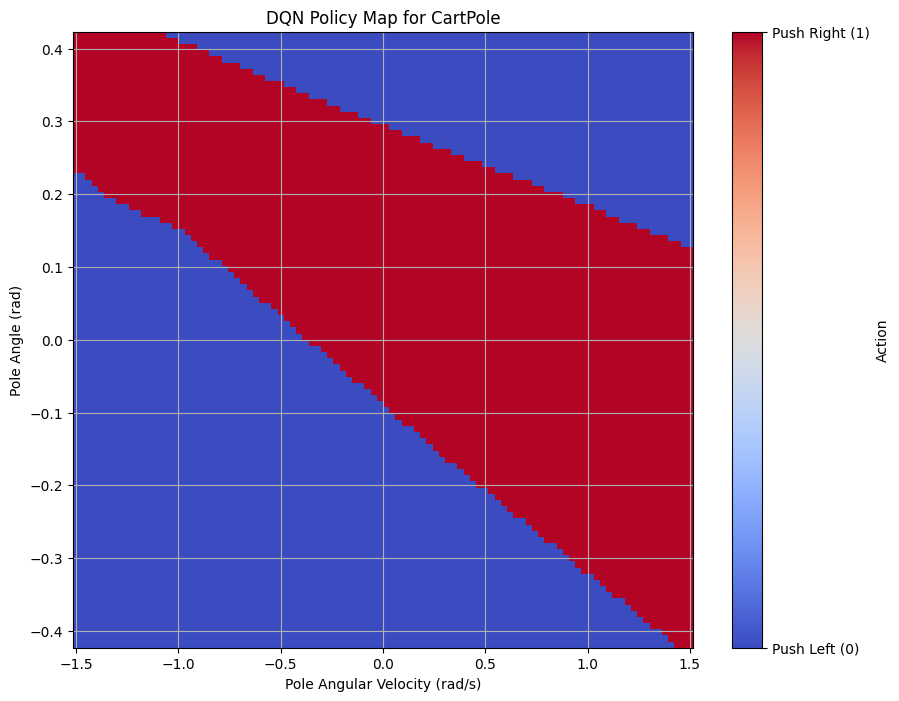

In [268]:
def visualize_policy_map(trained_net, env):
    # Set the network to evaluation mode
    trained_net.eval()
    
    # --- 1. Create the Grid ---
    # Define the range for Pole Angle and Pole Angular Velocity
    # Use the environment's observation space limits for robust ranges
    angle_range = np.linspace(env.observation_space.low[2], env.observation_space.high[2], 100)
    ang_vel_range = np.linspace(-1.5, 1.5, 100) # Manually set a reasonable range for velocity
    
    # Create a grid to store the optimal action for each state
    policy_map = np.zeros((len(angle_range), len(ang_vel_range)))

    # --- 2. Iterate and Query the Network ---
    for i, angle in enumerate(angle_range):
        for j, ang_vel in enumerate(ang_vel_range):
            # Fix Cart Position and Velocity to 0
            state = torch.tensor([0.0, 0.0, angle, ang_vel], dtype=torch.float32)
            
            # Use torch.no_grad() for faster inference
            with torch.no_grad():
                # The network expects a batch, so we unsqueeze to add a batch dimension
                q_values = trained_net(state.unsqueeze(0))
                # The best action is the one with the highest Q-value
                action = torch.argmax(q_values).item()
                policy_map[i, j] = action

    # --- 3. Plot the Action Map ---
    plt.figure(figsize=(10, 8))
    # Use pcolormesh for a colored grid
    # Transpose the map because imshow/pcolormesh expects (row, col) which corresponds to (y, x)
    plt.pcolormesh(ang_vel_range, angle_range, policy_map, cmap='coolwarm', shading='auto')
    
    plt.colorbar(ticks=[0, 1], label='Action').ax.set_yticklabels(['Push Left (0)', 'Push Right (1)'])
    plt.title('DQN Policy Map for CartPole')
    plt.xlabel('Pole Angular Velocity (rad/s)')
    plt.ylabel('Pole Angle (rad)')
    plt.grid(True)
    plt.show()

visualize_policy_map(Q_net, env)